# Reducing Numerical Errors with Neural Operators

In this example we will target numerical errors that arise in the discretization of a continuous PDE $\mathcal P^*$, i.e. when we formulate $\mathcal P$. This approach will demonstrate that, despite the lack of closed-form descriptions, discretization errors often are functions with regular and repeating structures and, thus, can be learned by a neural operator. Once trained, the neural network (NN) can be evaluated locally to improve the solution of a PDE-solver, i.e., to reduce its numerical error. The resulting method is a hybrid one: it will always perform (a coarse) PDE solve, and then improve it at runtime with corrections inferred by an NN.

 
Pretty much all numerical methods contain some form of iterative process: repeated updates over time for explicit solvers, or within a single update step for implicit or steady-state solvers. 
An example for the second case could be found [here](https://github.com/tum-pbs/CG-Solver-in-the-Loop),
but below we'll target the first case, i.e. iterations over time.
[[run in colab]](https://colab.research.google.com/github/tum-pbs/pbdl-book/blob/main/diffphys-code-sol.ipynb)


## Problem formulation

In the context of reducing errors, it's crucial to have a _differentiable physics solver_, so that the learning process can take the updates of the solver into account. This interaction is not possible with supervised- or PINN-based training. Even small inference errors of a supervised NN accumulate over time, and lead to a data distribution that differs from the distribution of the pre-computed data. This distribution shift leads to sub-optimal results, or even cause blow-ups of the solver.

In order to learn the error function, we'll consider two different discretizations of the same PDE $\mathcal P^*$: 
a _reference_ version, which we assume to be accurate and high fidelity, with a discretized version 
$\mathcal P_r$, and solutions $\mathbf r \in \mathscr R$, where $\mathscr R$ denotes the manifold of solutions of $\mathcal P_r$.
In parallel to this, we have a lower fidelty solver for the same PDE, which we'll refer to as the _source_ version, as this will be the solver that our NN should later on interact with. Analogously,
we have $\mathcal P_s$ with solutions $\mathbf s \in \mathscr S$.
After training, we'll obtain a _hybrid_ solver that the source solver $\mathcal P_s$ in conjunction with a trained operator to obtain improved solutions, i.e., solutions that are closer to the ones produced by $\mathcal P_r$.

```{figure} resources/diffphys-sol-manifolds.jpeg
---
height: 150px
name: diffphys-sol-manifolds
---
Visual overview of coarse and reference manifolds
```



Let's assume $\mathcal{P}$ advances a solution by a time step $\Delta t$, and let's denote $n$ consecutive steps by a superscript:
$
\newcommand{\pde}{\mathcal{P}}
\newcommand{\pdec}{\pde_{s}}
\newcommand{\vc}[1]{\mathbf{s}_{#1}} 
\newcommand{\vr}[1]{\mathbf{r}_{#1}} 
\newcommand{\vcN}{\vs}          
\newcommand{\project}{\mathcal{T}}   
\pdec^n ( \mathcal{T} \vr{t} ) = \pdec(\pdec(\cdots \pdec( \mathcal{T} \vr{t}  )\cdots)) .
$ 
The corresponding state of the simulation is
$
\mathbf{s}_{t+n} = \mathcal{P}^n ( \mathcal{T} \mathbf{r}_{t} ) .
$
Here we assume a mapping operator $\mathcal{T}$ exists that transfers a reference solution to the source manifold. This could, e.g., be a simple downsampling operation.
Especially for longer sequences, i.e. larger $n$, the source state 
$\newcommand{\vc}[1]{\mathbf{s}_{#1}} \vc{t+n}$
will deviate from a corresponding reference state
$\newcommand{\vr}[1]{\mathbf{r}_{#1}} \vr{t+n}$. 
This is what we will address with an NN-based operator in the following.

As before, we'll use an $L^2$-norm to quantify the deviations, i.e., 
an error function $\newcommand{\loss}{e} 
\newcommand{\corr}{\mathcal{C}} 
\newcommand{\vc}[1]{\mathbf{s}_{#1}} 
\newcommand{\vr}[1]{\mathbf{r}_{#1}} 
\loss (\vc{t},\mathcal{T} \vr{t})=\Vert\vc{t}-\mathcal{T} \vr{t}\Vert_2$. 
Our learning goal is to train at a correction operator 
$\mathcal{C} ( \mathbf{s} )$ such that 
a solution to which the correction is applied has a lower error than the original unmodified (source) 
solution: $\newcommand{\loss}{e} 
\newcommand{\corr}{\mathcal{C}} 
\newcommand{\vr}[1]{\mathbf{r}_{#1}} 
\loss ( \mathcal{P}_{s}( \corr (\mathcal{T} \vr{t}) ) , \mathcal{T} \vr{t+1}) < \loss ( \mathcal{P}_{s}( \mathcal{T} \vr{t} ), \mathcal{T} \vr{t+1})$. 

The correction operator  
$\newcommand{\vcN}{\mathbf{s}} \newcommand{\corr}{\mathcal{C}} \corr (\vcN | \theta)$ 
is represented as a deep neural network with weights $\theta$
and receives the state $\mathbf{s}$ to infer an additive correction field with the same dimension.
To distinguish the original states $\mathbf{s}$ from the corrected ones, we'll denote the latter with an added tilde $\tilde{\mathbf{s}}$.
The overall learning goal now becomes

$$
\newcommand{\corr}{\mathcal{C}}  
\newcommand{\vr}[1]{\mathbf{r}_{#1}} 
\text{arg min}_\theta \big( ( \mathcal{P}_{s} \corr )^n ( \mathcal{T} \vr{t} ) - \mathcal{T} \vr{t+n} \big)^2
$$

To simplify the notation, we've dropped the sum over different samples here (the $i$ from previous versions).
A crucial bit that's easy to overlook in the equation above, is that the correction depends on the modified states, i.e.
it is a function of
$\tilde{\mathbf{s}}$, so we have 
$\newcommand{\vctN}{\tilde{\mathbf{s}}} \newcommand{\corr}{\mathcal{C}} \corr (\vctN | \theta)$.
These states actually evolve over time when training. They don't exist beforehand.

**TL;DR**:
We'll train a neural operator $\mathcal{C}$ to reduce the numerical errors of a simulator with respect to a more accurate reference. It's crucial to have the _source_ solver realized as a differential physics operator, such that it provides gradients for an improved training of $\mathcal{C}$.

<br>

---


## Getting started with the implementation

The following replicates an experiment from [Solver-in-the-loop: learning from differentiable physics to interact with iterative pde-solvers](https://ge.in.tum.de/publications/2020-um-solver-in-the-loop/) {cite}`um2020sol`, further details can be found in section B.1 of the [appendix](https://arxiv.org/pdf/2007.00016.pdf) of the paper.

First, let's import the necessary libraries, most importantly [phiflow](https://tum-pbs.github.io/PhiFlow/) and [PyTorch](https://pytorch.org/), and let's get the device handling out of the way, so that we can focus on the _interesting_ parts...

In [1]:
import os, sys, logging, argparse, pickle, glob, random, pylab, time
from tqdm import tqdm
from phi.torch.flow import *

random.seed(42) 
np.random.seed(42)
#math.seed(42) # phiflow seed
math.set_global_precision(32)

USE_CPU = 0
TORCH.set_default_device("GPU")
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
if USE_CPU > 0:
    device = 'cpu' 
device = torch.device(device)
print("Using device: "+str(device))

Using device: cuda:0


And while we're at it, we also set the random seed - obviously, 42 is the ultimate choice here 🙂

## Simulation setup

Now we set up the _source_ simulation $\mathcal{P}_{s}$. 
Note that we won't deal with 
$\mathcal{P}_{r}$
in this notebook: the downsampled reference data is from the high-fidelty solve is already contained in the training data set. It was generated with a four times finer spatial and temporal discretization. Below we're focusing on the interaction of the source solver and the NN. 

The `KarmanFlow` solver below simulates a relatively standard Navier-Stokes wake flow case with a spherical obstacle in a rectangular domain, and an explicit viscosity solve to obtain different Reynolds numbers. This is the geometry of the setup:

```{figure} resources/diffphys-sol-domain.png
---
height: 200px
name: diffphys-sol-domain
---
Domain setup for the wake flow case (sizes in the imlpementation are using an additional factor of 100).
```

The solver applies inflow boundary conditions for the y-velocity with a pre-multiplied mask (`vel_BcMask`), to set the y components at the bottom of the domain during the simulation step. This mask is created with the `HardGeometryMask` from phiflow, which initializes the spatially shifted entries for the components of a staggered grid correctly. The simulation step is quite straight forward: it computes contributions for viscosity, inflow, advection and finally makes the resulting motion divergence free via an implicit pressure solve:

In [2]:
class KarmanFlow():
    def __init__(self, domain):
        self.domain = domain

        self.vel_BcMask = self.domain.staggered_grid(HardGeometryMask( Box(y=(None, 5), x=None) ) )
    
        self.inflow = self.domain.scalar_grid(Box(y=(5,10), x=(25,75)) ) # scale with domain if necessary!
        self.obstacles = [Obstacle(Sphere(center=tensor([50, 50], channel(vector="y,x")), radius=10))] 

    def step(self, marker_in, velocity_in, re, res, buoyancy_factor=0, dt=1.0):
        velocity = velocity_in
        marker = marker_in

        # viscosity
        velocity = phi.flow.diffuse.explicit(u=velocity, diffusivity=1.0/re*dt*res*res, dt=dt)
        
        # inflow boundary conditions
        velocity = velocity*(1.0 - self.vel_BcMask) + self.vel_BcMask * (1,0)

        # advection 
        marker = advect.semi_lagrangian(marker+ 1. * self.inflow, velocity, dt=dt)   
        velocity = advected_velocity = advect.semi_lagrangian(velocity, velocity, dt=dt)

        # mass conservation (pressure solve)
        pressure = None
        velocity, pressure = fluid.make_incompressible(velocity, self.obstacles)
        self.solve_info = { 'pressure': pressure, 'advected_velocity': advected_velocity }
        
        return [marker, velocity]

    

Note that the `marker` density here denotes a passively advected marker field, and not the density of the fluid. Below we'll only be focusing on the velocity for the correction task. The marker density is tracked purely for visualization purposes.


## Network and transfer functions

We'll also define a simple neural networks to represent the operator
$\newcommand{\vcN}{\mathbf{s}} \newcommand{\corr}{\mathcal{C}} \corr$. We'll use fully convolutional networks, i.e. networks without any fully-connected (MLP) layers. We'll use phiflow's network tools to set up a `conv_net` with a given number of layers as specified in the `layers` list.
The inputs to the network are 3 fields: 
- 2 fields with x,y velocity
- the Reynolds number as constant channel.

The output is: 
- a 2 component field containing the x,y velocity.

In the conv-net, the input dimensions are determined from input tensor (it has three channels: u,v, and Re). Then we process the data via the sequence of conv layers and activations with 32 (and 48) features each, before reducing to 2 channels in the output. The code below also re-initializes the convolutions with a uniform Xavier initializer that is downscaled with a gain of `0.1`. The simplifies training by avoiding overly large values at the beginning. With it, we can direclty activate unrolling multiple steps. Without it, we'd need to add a curriculum and make sure the network is trained for a bit to find a suitable range for the corrections, before being applied to longer sequences via unrolling.

While we're at it, we (of course) also checking the number of paramters in the network. This is a crucial metric for the approximate computational cost of the NN.

In [3]:

layers = [32,32,32] # small
#layers = [32,48,48,48,32] # a bit larger
#network = conv_net(in_channels=3,out_channels=2,layers=layers)
network = res_net(in_channels=3,out_channels=2,layers=layers)
print(network)

# reinit 
import torch.nn as nn
for m in network.modules():
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight, gain=0.1)

print("Total number of trainable parameters: "+ str( sum(p.numel() for p in network.parameters()) ))

ResNet(
  (Res_in): ResNetBlock(
    (sample_input): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    (bn_sample): Identity()
    (bn1): Identity()
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): Identity()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (Res1): ResNetBlock(
    (sample_input): Identity()
    (bn_sample): Identity()
    (bn1): Identity()
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): Identity()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (Res2): ResNetBlock(
    (sample_input): Identity()
    (bn_sample): Identity()
    (bn1): Identity()
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): Identity()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (Res_out): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
)
Parameters: 47330


Next, we're defining transfer functions which are pretty important: they don't modify any content, but transform the simulation state into suitable data structures for the different software packages that are used: staggered grids for the solver, pytorch tensors for the NN, and another helper to turn the numpy output of the dataloader into phiflow grids and values that can easily be used in the NS solver.

The `to_phiflow` function takes a pytorch tensor `batch` and transforms the two relevant channels (1 and 2 in the second dimension for x and y) into a staggered grid for phiflow. The only caveat here is the size of the arrays involved: 
due to the closed and open boundaries and the staggered grid, phiflow expects arrays of size
`[64, 31]` and  `[65, 32]` for x and y, respectively. In phiflow's `math.tensor` call we then have to tell phiflow about the batch and spatial dimensions.

The `to_pytorch` function receives a small list with `[marker,velocity]`, and 
uses the two vector components of the staggered grid velocity via `vector['x']` and `vector['y']` to discard the outermost layer of the velocity field grids. This gives two tensors of equal size that are stacked along the `channels` dimension. 
It also adds a constant channel via `math.ones` that is multiplied by the desired Reynolds number in `ext_const_channel` onto the stack. The resulting stack of grids is turned into a single pytorch tensor via `native(order='batch,channels,y,x')` and represents the input to the neural network. 

The last function is a helper to transform the output of the dataloader into data structurs for phiflow.
The data loader produces numpy arrays, and they're transformed into a velocity grid with the `to_phiflow` function from above. At the same time, we're normalizing the Reynolds number for the NN operator, and we keep the original one as a scalar value for the phiflow solver, as the latter uses "physical units", in contrast to the network.


In [4]:
def to_phiflow(batch):
    vx = batch[:,1,:-1,:-1]
    vy = batch[:,2,:,:] # fine
    
    #print("v_dims "+str([vx.shape,vy.shape])) # example for debugging
    # v_dims should be vx [torch.Size([B, 64, 31]),  vy torch.Size([B, 65, 32])]
    
    vel = domain.staggered_grid( math.stack( [
                            math.tensor(vy, math.batch('batch'), math.spatial('y, x')),
                            math.tensor(vx, math.batch('batch'), math.spatial('y, x')),
                        ], math.dual(vector="y,x")
                    ) ) 
    return vel

def to_pytorch(marker_vel, Re):
    # align the sides the staggered velocity grid making its size the same as the centered grid
    grid = math.stack(
        [
            math.pad( marker_vel[1].vector['x'].values, {'x':(0,1)} , math.extrapolation.ZERO), # x component
            marker_vel[1].vector['y'].y[:-1].values,                                            # y component
            math.ones(marker_vel[0].shape)*Re                                                   # constant Re
        ],
        math.channel('channels')
    ).native(order='batch,channels,y,x') 
    return grid

def to_solver(inputs):
    marker_in = inputs[:,0,:-1,:]
    marker_in = domain.scalar_grid( math.tensor(marker_in, math.batch('batch'), math.spatial('y, x')) )
    v_in = to_phiflow(inputs)
    Re = math.tensor(inputs[0,3, 0,0].detach()) # Scalar , get first index 0,0

    Re_norm = (Re - math.tensor(dataloader.dataset.const_mean)) / math.tensor(dataloader.dataset.const_std[0])
    Re_norm = float(Re_norm.native().detach()) # we just need a single number

    return marker_in, v_in, Re, Re_norm


---

## Training setup

Now we also need to take care to set up the training, i.e. intialize data sets and optimizers. The latter is relatively easy, we'll use an Adam optimizer with a given learning rate, and this is also a good time to define the batch size (3 is a good default here).


In [5]:
LEARNING_RATE = 1e-3
#LEARNING_RATE = 3e-4  #  NT_DEBUG
optimizer = adam(network, LEARNING_RATE)

# one of the most crucial parameters: how many simulation steps to look into the future in each training step
MSTEPS = 4

BATCH_SIZE = 3
#BATCH_SIZE = 10 # NT_DEBUG


The most important and interesting parameter is `MSTEPS`. It defines the number of simulation steps that are unrolled at each training iteration. This directly influences the runtime of each training step, as we first have to simulate all steps forward, and then backpropagate the gradient through all `MSTEPS` simulation steps interleaved with the NN evaluations. However, this is where we'll receive important feedback in terms of gradients how the inferred corrections actually influence a running simulation. Hence, larger `msteps` are typically better. Ideally, the training also increases the number of `MSTEPS` over time in the form of a curriculum, but we'll omit that to keep the code simpler.

For the training data itself, we can use PBDL's data loader class, which automatically downloads the data from HuggingFace (if necessary), and returns a class that we can easily iterate over to get a new batch for training. Here we need to specify the `BATCH_SIZE`, and we select simulations 0 to 5 from the dataset, in order to keep cases 6 to 9 for testing later on. The first 6 contain an intermediate range of Reynolds numbers, so that we can keep some new ones outside of this range for testing generalization later on. The dataloader also needs to provide enough steps of the ground truth reference to compute the loss for the full unrolled trajectory. This is ensured via `time_steps=MSTEPS+1, intermediate_time_steps=True`.

In [6]:
import pbdl.torch.loader

dataloader = pbdl.torch.loader.Dataloader("local-sol", batch_size=BATCH_SIZE, sel_sims=[0,1,2,3,4,5],
                                          time_steps=MSTEPS, intermediate_time_steps=True, shuffle=True, normalize=False)

dataloader.dataset.__prepare_norm_data__() # manual?
dataloader.dataset.const_mean = dataloader.dataset.dset["norm_const_mean"][()]
dataloader.dataset.const_std  = dataloader.dataset.dset["norm_const_std"][()]


Successfully loaded local-sol with 10 simulations (6 selected) and 496 samples each.


Additionally, we defined several global variables to control the training and the simulation in the next code cell.

The fluid solver object is called `simulator` below. In order to easily create grids in phiflow it uses a phiflow `Domain` object, which mostly exists for convenience purposes: it stores resolution, physical size, and boundary conditions of the domain. This information needs to be passed to every grid, and hence it's convenient to have it in one place in the form of the `Domain`. For the setup described above, we need different boundary conditions along x and y: closed walls, and free flow in and out of the domain, respecitvely.

In [7]:
# this is the actual resolution in terms of cells for phiflow (not too crucial)
SOURCE_RES = [64,32] 

# this is the physical size in terms of abstract units for the bounding box of the domain (it's important for conversions between computational and physical units)
LENGTH = 100.

# for readability
from phi.physics._boundaries import Domain, OPEN, STICKY as CLOSED

BNDS = {
    'y':(phi.physics._boundaries.OPEN,  phi.physics._boundaries.OPEN) ,
    'x':(phi.physics._boundaries.STICKY,phi.physics._boundaries.STICKY) 
}

domain = phi.physics._boundaries.Domain(y=SOURCE_RES[0], x=SOURCE_RES[1], boundaries=BNDS, bounds=Box(y=2*LENGTH, x=LENGTH))
simulator = KarmanFlow(domain=domain)

/tmp/ipykernel_652541/1761501079.py:8: FutureWarning: Domain (phi.physics._boundaries) is deprecated and will be removed in a future release.
Please create grids directly, replacing the domain with a dict, e.g.
    domain = dict(x=64, y=128, bounds=Box(x=1, y=1))
    grid = CenteredGrid(0, **domain)
  from phi.physics._boundaries import Domain, OPEN, STICKY as CLOSED
/tmp/ipykernel_652541/1761501079.py:15: DeprecationWarning: Domain is deprecated and will be removed in a future release. Use a dict instead, e.g. CenteredGrid(values, extrapolation, **domain_dict)
  domain = phi.physics._boundaries.Domain(y=SOURCE_RES[0], x=SOURCE_RES[1], boundaries=BNDS, bounds=Box(y=2*LENGTH, x=LENGTH))
/tmp/ipykernel_652541/1761501079.py:15: FutureWarning: Domain is deprecated and will be removed in a future release. Use a dict instead, e.g. CenteredGrid(values, extrapolation, **domain_dict)
  domain = phi.physics._boundaries.Domain(y=SOURCE_RES[0], x=SOURCE_RES[1], boundaries=BNDS, bounds=Box(y=2*LENG

## Interleaving simulation and NN

In order to efficiently run training with non-trivial simulations, it's a good idea to keep the runtime in mind. For efficient runs it's especially important to involve the GPUs used for training, and keep the data on the GPU as much as possible. For phiflow, this can largely be achieved by jit-compiling the central steps, and in the next code cell we'll do this for the Navier-Stokes simulation step. It involves an implicit pressure solve, among others, and is potentially called multiple times for each forward and backwards pass. Hence this is a good candidate for jit-compilation. (Try removing the `@jit_compile` statement to experience the slow-down yourself.)


In [8]:
@jit_compile 
def simulation_step(marker,velocity,re,resolution):
    m,v = simulator.step(
        marker_in=marker,
        velocity_in=velocity,
        re=re, res=resolution 
    )
    return m,v

Next comes the **most crucial** step in the whole setup: we define a function that encapsulates the chain of simulation steps and network evaluations in each training step. With the helper functions we've set up so far, it's actually pretty simple: we loop `MSTEPS` times, calling the simulator via `simulator_step` for an input state, and afterwards evaluate the correction operator via `network(to_pytorch(...))`. The NN correction is then added to the last simulation state in the `prediction` list of states. This list keeps around the marker density and velocity for each time step.

Note that apart from the Reynolds number, we're not normalizing the states themselves as they're already in the -1 to 1 range. For other simulations it would be a good idea to normalize before invoking the network, and de-normalizing afterwards for the subsequent physics solving step.

In [9]:
def training_step(inputs_targets):
    [inputs, targets] = inputs_targets
    marker_in, v_in, Re, Re_norm = to_solver(inputs)
    prediction = [ [marker_in,v_in] ]
    loss = 0

    for i in range(MSTEPS):
        m2,v2 = simulation_step(
            marker=prediction[-1][0],
            velocity=prediction[-1][1],
            re=Re, resolution=SOURCE_RES[1]  
        )

        net_in = to_pytorch([m2,v2],Re_norm)
        net_out = network(net_in)

        cy = net_out[:,1,:,:] # pad y
        cy = torch.nn.functional.pad(input=cy, pad=(0,0, 0,1), mode='constant', value=0)
        cx = net_out[:,0,:,:-1]  
        
        v_corr = domain.staggered_grid( math.stack( [
                            math.tensor(cy, math.batch('batch'), math.spatial('y, x')),
                            math.tensor(cx, math.batch('batch'), math.spatial('y, x')),
                        ], math.dual(vector="y,x")
                    ) ) 

        prediction += [ [domain.scalar_grid(m2) , v2 + v_corr] ]
        vdiff = prediction[-1][1] - to_phiflow(targets[:,i,...]) 
        loss += field.l2_loss(vdiff) 

    return loss, prediction



The `training_step` function above also directly evaluates and returns the loss. Here, we simply use an $L^2$ loss over the grids (in phiflow `fields`) for the whole sequence, i.e. over the unrolled `msteps`. In `vdiff` we're simply computing the difference between the targets and the current prediction, and then compute its `l2_loss`.

With the training step, the training is quite simple: all that's left to do is to let the optimizer compute the gradients to minimize the loss. Phiflow provides a helper function for this: `update_weights`. We provide the neural network, the optimizer, and the function to compute the loss (the first return value of `training_step`). We simply loop `EPOCHS` times over enumerating the full dataset from the `dataloader`. The progress bar `pbar` below is simply eyecandy to track the progress of the training. Because the jit compilation of the simulator is triggered in the very first step takes a bit longer, but the subsequent ones should be substantially faster. The code below also saves the network state every epoch _N_ in a file `net-N.pickle`.

In [10]:
EPOCHS = 5

pbar = tqdm(initial=0, total=EPOCHS*len(dataloader), ncols=96) 

for epoch in range(EPOCHS):  
    for b, (input_cpu, targets_cpu) in enumerate(dataloader):
        input = torch.tensor(input_cpu, dtype=torch.float32).to(device); 
        targets = torch.tensor(targets_cpu, dtype=torch.float32).to(device)

        loss, prediction = update_weights(network, optimizer, training_step, [input, targets])

        pbar.set_description("loss "+str(np.sum(loss.numpy("batch"))), refresh=False); pbar.update(1)  

    torch.save(network.state_dict(), "net-"+str(epoch)+".pickle") 

pbar.close()

  0%|                                                                  | 0/4960 [00:00<?, ?it/s]/tmp/ipykernel_652541/1256326133.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input_cpu, dtype=torch.float32).to(device);
/tmp/ipykernel_652541/1256326133.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets_cpu, dtype=torch.float32).to(device)
/home/thuerey/anaconda3/envs/torch24/lib/python3.12/site-packages/phiml/math/_optimize.py:631: UserWarning: Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).
  warnings.warn("Possible rank deficienc


Note that each call to `update_weights` internally performs all 3 interleaved simulation steps and neural network calls, and back-propagates gradients for the whole chain. So, for the 3 steps, the first network will receive feedback whether it's inferred correction influenced the two subsequent states towards the right direction or now.

With the default parameters, the loss should go down from 50 initially to circa 5 (more epochs and larger/deeper networks could bring it down further). The decreasing loss is a good sign, but of course it's even more important to see how the resulting NN-solver combination fares on new inputs. With this training approach we've realized a hybrid solver, consisting of a regular _source_ simulator, and a network operator that was trained to specifically interact with this simulator for a chosen domain of simulation cases.


## Test evaluation 

In order to evaluate the performance of our "AI-powered solver", we essentially only need to repeat the inner loop of each training iteration for more steps. While we were limited to `msteps` evaluations at training time, we can now run our solver for arbitrary lengths. This is a good test for how well our solver has learned to keep the data within the desired distribution, and represents a generalization test for longer rollouts.

We also need a set of new data. Below, we'll use the previously unused last four simulations of the dataset that was downloaded above. We simply instantiate a new dataloader with `sel_sims=[6,7,8,9]`. 

In [11]:
# testing

dataloader_test = pbdl.torch.loader.Dataloader("local-sol", batch_size=1, time_steps=200, sel_sims=[6,7,8,9],
                                          intermediate_time_steps=True, shuffle=True, normalize=False)

dataloader_test.dataset.__prepare_norm_data__() # manual?
dataloader_test.dataset.const_mean = dataloader_test.dataset.dset["norm_const_mean"][()]
dataloader_test.dataset.const_std  = dataloader_test.dataset.dset["norm_const_std"][()]

Successfully loaded local-sol with 10 simulations (4 selected) and 300 samples each.


In case you have a pre-trained network, this is a good point to load a model. By default, we assume the training above was completed, so it's not necessary to load anything.

In [12]:
# optionally load
if False:
    fn = "net-"+str(EPOCHS-1)+".pickle" # load last
    network.load_state_dict(torch.load(fn, map_location=device, weights_only=True))
    print("Loaded "+fn)

We can reuse a lot of the solver code from above, but in the following, we will consider two simulated versions: for comparison, we'll run one reference simulation in the _source_ manifold (i.e. based on $\mathcal P_s$, without any corrections applied). The second version is the actual result, we'll repeatedly compute the source solver plus the learned correction.

The `run_sim` function below switches between these two variants depending on whether a neural operator is provided in `network`. Without it, it simply runs the source solver and appends the states. With a `network` it runs the full hybrid solver. Both cases compute error w.r.t. reference along the way. For analysis and visualization later on, the function returns the correction and references in addition to the relative errors and the actual states computed by the solver.

In [13]:
def run_sim(inputs, targets, steps, network=None): 
    marker_in, v_in, Re, Re_norm = to_solver(inputs)

    simtype = "With corr."
    if (network==None): simtype = "Sim. only"
    print("Running test with Re="+str(Re)+", "+simtype)
    
    prediction = [ [marker_in,v_in] ]
    correction = [ [marker_in,v_in] ]
    refs = [ v_in ]
    errors = []

    for i in tqdm(range(steps), desc=simtype, ncols = 64):
        marker_sim,v_sim = simulation_step(
            marker=prediction[-1][0],
            velocity=prediction[-1][1],
            re=Re, resolution=SOURCE_RES[1]  # take Re from constant field
        )

        if network: # run hybrid solver with trained Neural op
            net_in = to_pytorch([marker_sim,v_sim],Re_norm)
            net_out = network(net_in)
    
            cy = net_out[:,1,:,:] # pad y
            cy = torch.nn.functional.pad(input=cy, pad=(0,0, 0,1), mode='constant', value=0)
            cx = net_out[:,0,:,:-1]  
            
            v_corr = domain.staggered_grid( math.stack( [
                                math.tensor(cy, math.batch('batch'), math.spatial('y, x')),
                                math.tensor(cx, math.batch('batch'), math.spatial('y, x')),
                            ], math.dual(vector="y,x")
                        ) ) 

            prediction += [ [domain.scalar_grid(marker_sim) , v_sim + v_corr] ]
            correction += [ [domain.scalar_grid(marker_sim) , v_corr] ] 
            
        else: # only low-fidelity solver           
            prediction += [ [domain.scalar_grid(marker_sim) , v_sim ] ]

        refs += [to_phiflow(targets[:,i,...])]
        vdiff = prediction[i][1] - refs[-1]
        
        error_phi = field.l1_loss(vdiff) 
        errors += [float( error_phi.native("batch")[0] / field.l1_loss(refs[-1]).native("batch")[0] )]
    
    return errors, prediction, refs, correction


With `next(iter(dataloader_test))` we'll get a new state from the dataloader with a previously unseen Reynolds number. Then we'll run source and hybrid solver for `ROLLOUT_STEPS` iterations starting from the same initial state. Similar to training, we'll first get an initial state and reference states from the dataloader in `input` and `targets`. (Due to the random sampling, you might need to run this multiple times to e.g. get one of the higher Re cases.)



In [24]:
# get a sample
(input_cpu, targets_cpu) = next(iter(dataloader_test))
input = torch.tensor(input_cpu, dtype=torch.float32).to(device) 
targets = torch.tensor(targets_cpu, dtype=torch.float32).to(device)
print("Re ",math.tensor(input[0,3, 0,0].detach()))

Re  1920000.0


/tmp/ipykernel_652541/345484244.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input_cpu, dtype=torch.float32).to(device)
/tmp/ipykernel_652541/345484244.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets_cpu, dtype=torch.float32).to(device)


The interesting question of course is: how much does the NN operator actually improve the accuracy of the low-fidelity _source_ solver? This is captured by the relative $L_2$ errors computed each time by the `run_sim` function. It measures the squared distance in comparison to the squared magnitudes of the reference velocities. The cell above directly plots the aggregated errors. 

Below, we run the hybrid solver with its trained Neural correction operator and the low-fidelity solver alone for comparison.
`ROLLOUT_STEPS` below determines the number of time steps to compute with both variants. The cell also directly outputs the mean relative error.
Due to the stochastic training and numerical round-off errors, the results can vary slightly over different runs, but in general the hybrid solver with its Neural correction operator should show a significantly reduced numerical error: typically 5-6x lower than the low-fidelity solver. 

**This shows the central objective of this training setup has been achieved: the hybrid solver yields substantially reduced numerical errors and generalizes to new Reynolds numbers 👍**

In [29]:
ROLLOUT_STEPS = 100
err_lowfid_only, prediction_lowfid_only, refs, _   = run_sim(input, targets, ROLLOUT_STEPS)
err_corrected,   prediction_corrected  , _ , corrs = run_sim(input, targets, ROLLOUT_STEPS, network)
print("Rel. L2 errors: low-fidelity:", float(np.mean(err_lowfid_only))," corrected:", float(np.mean(err_corrected)) )

Running test with Re=1920000.0, Sim. only


Sim. only: 100%|██████████████| 100/100 [00:15<00:00,  6.45it/s]


Running test with Re=1920000.0, With corr.


With corr.: 100%|█████████████| 100/100 [00:36<00:00,  2.73it/s]

Rel. L2 errors: low-fidelity: 0.13189382933080196  corrected: 0.0202646186389029


Now we'll plot and compare the two versions in more detail. The next graph shows how the errors evolve over time. The relative errors of the low-fidelity solver rise linearly over time, while the hybrid solver yields a much slower increase. For larger networks and successful training runs, it can pretty much suppress any increase, and keep the errors at a very low level. This indicates, that it can successfully nudge the low-fidelity solver to preserve the accuracy of the targets. Note that this job would be much more difficult without the base solver: then the NN would need to do _all_ the work. Here, it can rely on the prediction of the coupled solver, and a small correction typically suffices.

MAE for low-fidelity:  0.13189382933080196  , and hybrid:  0.0202646186389029


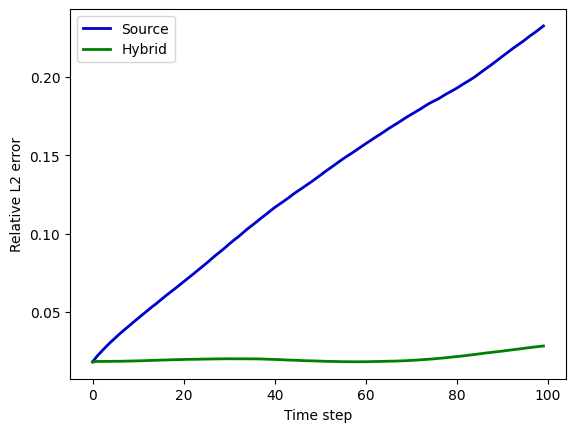

In [26]:
fig = pylab.figure().gca()
pltx = np.linspace(0,ROLLOUT_STEPS-1,ROLLOUT_STEPS)
fig.plot(pltx, err_lowfid_only, lw=2, color='mediumblue', label='Source')  
fig.plot(pltx, err_corrected,   lw=2, color='green', label='Hybrid')
pylab.xlabel('Time step'); pylab.ylabel('Relative L2 error'); fig.legend()

print("MAE for low-fidelity: ",np.mean(err_lowfid_only)," , and hybrid: ",np.mean(err_corrected) )

While the quantified results give an important summary of the performance of our Neural operator, it's important to sanity check these results to make sure the NN works as intended. In the next cell, we'll plot the states of the reference, the low-fidelity solver and the hybrid solver side-by-side. Additionally, we'll plot the errors made by both solvers on the right side.

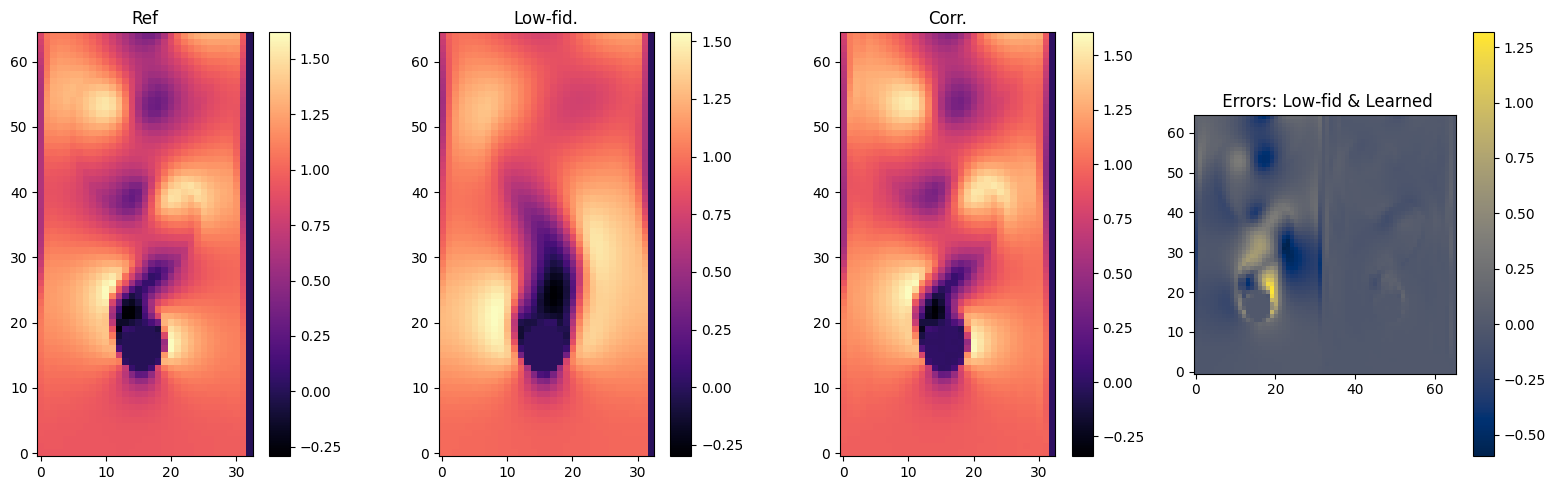

In [27]:
# which step from which batch to show , by default shows last step from first case
STEP = ROLLOUT_STEPS
BATCH = 0 
NUM_SHOW = 4
PRINT_STATS = False # optional, print statistics

fig, axes = pylab.subplots(1, 4, figsize=(16, 5)) 
i = 0

v = refs[STEP].staggered_tensor().numpy('batch,y,x,vector')[BATCH,:,:,0]
if PRINT_STATS: print(["reference ", BATCH, i, np.mean(v),  np.min(v) ,  np.max(v)])
axes[i].set_title(f"Ref")
im=axes[i].imshow( v , origin='lower', cmap='magma') ; 
pylab.colorbar(im) ; i=i+1; vy_ref=v

v = prediction_lowfid_only[STEP][1].staggered_tensor().numpy('batch,y,x,vector')[BATCH,:,:,0]
if PRINT_STATS: print(["low-fid. ", BATCH, i, np.mean(v),  np.min(v) ,  np.max(v)])
axes[i].set_title(f"Low-fid.")
im=axes[i].imshow( v , origin='lower', cmap='magma') ; 
pylab.colorbar(im) ; i=i+1; vy_lowfid=v

v = prediction_corrected[STEP][1].staggered_tensor().numpy('batch,y,x,vector')[BATCH,:,:,0]
if PRINT_STATS: print(["corrected", BATCH, i, np.mean(v),  np.min(v) ,  np.max(v)])
axes[i].set_title(f"Corr.")
im=axes[i].imshow( v , origin='lower', cmap='magma') ; 
pylab.colorbar(im) ; i=i+1; vy_corr=v

# show error side by side
err_lf   = vy_ref - vy_lowfid 
err_corr = vy_ref - vy_corr 
v = np.concatenate([err_lf,err_corr], axis=1)
axes[i].set_title(f" Errors: Low-fid & Learned")
im=axes[i].imshow( v , origin='lower', cmap='cividis') ; 
pylab.colorbar(im) ; i=i+1

pylab.tight_layout()    

This shows very clearly how the pure source simulation in the middle deviates from the reference on the left. The learned version stays much closer to the reference solution. 

The two per-cell error images on the right also illustrate this: the source version has much larger errors (i.e. brighter colors) that show how it systematically underestimates the vortices that should form. The error for the learned version is much more evenly distributed and significantly smaller in magnitude.

This concludes our evaluation. Note that the improved behavior of the AI-powered hybrid solver can be difficult to reliably measure with simple vector norms such as an MAE or $L^2$ norm. To improve this, we'd need to employ other, domain-specific metrics. In this case, metrics for fluids based on vorticity and turbulence properties of the flow would be applicable. However, in this text, we instead want to focus on DL-related topics and target another inverse problem with differentiable physics solvers in the next chapter.




## Next steps

* Turn off the differentiable physics training (by setting `msteps=1`), and compare it with the unrolled version. This yields a _supervised_ training, as no gradients need to flow through the solver anymore. Compare how much larger the relative errors are in this case.

* Likewise, train a network with a larger `msteps` setting, e.g., 8 or 16. Note that due to the recurrent nature of the training, you'll probably have to load a pre-trained state to stabilize the first iterations. How much does accuracy improve?

* Use the external github code to generate tougher test data, and run your trained NN on these cases. You'll see that a reduced training error not always directly correlates with an improved test performance.

